# Libaries to import 

In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *
import ldpcPython as ldpc

# Transmitsion
### Importing data, preparing them into the relevant formats, and saving/playing the output .wav file

In [14]:
# Load data here

# Random bits 
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')

# Original binary file
principia_binary = imageFileToBinary('Data_Files/PRINCIPIA.txt')
conv_binary = imageFileToBinary('Data_Files/circular_conv.bmp')
rickroll_binary  = imageFileToBinary('Data_Files/rickroll.gif')
kokoro_binary  = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')


song_binary = imageFileToBinary('Data_Files/dsmn.wav')


binary = song_binary

'''
byte = str_to_bytearray(binary)
newFile = open("Data_Files/doesthiswork.wav", "wb")
newFile.write(byte)
newFile.close()'''

'\nbyte = str_to_bytearray(binary)\nnewFile = open("Data_Files/doesthiswork.wav", "wb")\nnewFile.write(byte)\nnewFile.close()'

In [15]:
# Add metadata here
data_byte_length = int(len(binary)/8)
file_name = "plugfest_grp1.wav"

line = file_name+str(data_byte_length)
metadata = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
metadata = metadata[:len(file_name)*8] + '00000000' + metadata[len(file_name)*8:] + '00000000'

binary = metadata+binary
print(data_byte_length)
str_to_bytearray(binary)[:100]

208838


bytearray(b'plugfest_grp1.wav\x00208838\x00RIFF\xbe/\x03\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00@\x1f\x00\x00\x80>\x00\x00\x02\x00\x10\x00data\x9a/\x03\x00\xfc\xff\x07\x00\x80\x00\xaf\xff\xdd\xff\x14\x00u\x00\xb1\xff\xd0\x00Y\x01\x17\x01\xdf\xffv\x00\x06\x01K\x01\x9a')

In [16]:
# Error coding here

In [17]:
# Set the parameters for transmission
Mode = "C" # select mode from A, B, C

# Cyclic Prefix
CP_mode = {"A": 224, "B": 704, "C": 1184}

# DFT length 
N = 4096
CP = CP_mode[Mode]

# Number of time indecies we go back in time from the "optimal point"
guard = 5

# Number of known symbol repeats for every frame
CE_repeat = 20

# Number of data symbols in each frame
frame_data_length = 180

In [18]:
# Make your instructions ( THIS CAN BE MADE MORE COMPLICATED USING MAGNITUDE DATA FROM THE CHANNEL TF )
instruction = []
for i in range(int(N/2 - 1)):
    if i <1499 and i >= 99:
        instruction.append(1)
    else: 
        instruction.append(0)
        
# assuming 0 -> no data, 1 -> QPSK, 2 -> 16QAM
# find number of bits necessary for each OFDM symbol 
bits_in_ofdm_symbol = 0
for value in instruction: 
    bits_in_ofdm_symbol += value*2

In [19]:
# XOR operation

# This is information shared to the receiver
rand_binary = CE_binary[:bits_in_ofdm_symbol]  
data_binary_len = len(binary)

# Not shared to receiver
rand_for_xor = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]

# XOR the coded binary sequence
coded_binary = xor(binary, rand_for_xor)

In [20]:
# QAM modulation for the coded binary sequence

# Modulate the random sequence used for channel estimation using QPSK
# the first one uses all bins for known data
# the second one only uses the bins that contain data even for known data 
CE_modulated = qpsk(CE_binary)
#CE_modulated = varyingModulation_std(CE_binary, instruction, N, CE_binary, print_progress = True, max_odfm_symbol =1)

# Modulate the data symbols using the instruction array
data_modulated = varyingModulation_std(coded_binary, instruction, N, CE_binary, print_progress = True)

bitcount 2800
additional  696
data length  1670904
new data len  1671600
symbol number 100 is done.
symbol number 200 is done.
symbol number 300 is done.
symbol number 400 is done.
symbol number 500 is done.


In [21]:
# Chirp signal 
Start_F = 0
End_F = 8000
Time = 5*(CP+N)/fs

# Prepare chirp signal
chirp_signal = Chirp(Start_F,End_F,Time, volume = 100)

len(chirp_signal)

26400

In [22]:
# For channel esimation (CE)

# Prepare CE and payload data to be transmitted
CE_symbols, CE_Freq = ofdmSymbols(CE_modulated, CP, N)
Payload_symbols, Payload_Freq = ofdmSymbols(data_modulated, CP, N)

# Adjust the number of OFDM symbols in the payload so it has intger number of frame content
extra = frame_data_length - len(Payload_symbols)%frame_data_length
for i in range(extra):
    Payload_symbols = np.concatenate((Payload_symbols, [CE_symbols[1]]))
    

# Identify number of frames are present in the transmitted sequence
num_of_frames = int(len(Payload_symbols)/frame_data_length)

In [23]:
# Prepare what to actually transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_symbols[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_symbols, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

In [64]:
Tx = (Pause(0),) + tuple(Payload) + (chirp_signal,) # Pause 20 is just to remove any effects a the beginning of the transmission 
Transmit_time = round(len(np.concatenate(Tx))/fs, 2)

print("Transmit signal is", math.floor(Transmit_time/60), "min and", round(Transmit_time%60,3), "seconds")

Transmit signal is 1 min and 39.55 seconds


In [65]:
# Transmit the message / save the wav file
# playOutput = True to play the wave file
x = save_transmit( Tx , playOutput=False)

# Receiver

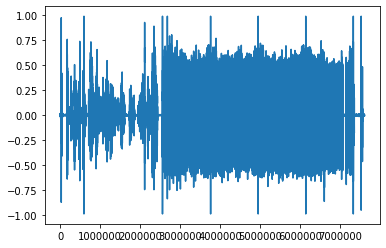

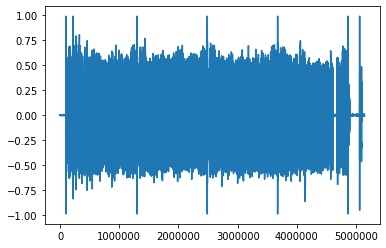

In [76]:
# Import the recorded signal
#y = audioDataFromFile('Wav_Files/challenge2_good_channel1.wav')
y = audioDataFromFile('Data_Files/pf3.wav')


# Find the first chirp and return the signal from just before that chirp
y_signal = detect_chirps(y, chirp_signal, 60)

plot_y(y)
plot_y(y_signal, f =1)

In [77]:
# length of each frame in time steps
length = (N + CP) * (frame_data_length + CE_repeat * 2) + len(chirp_signal)
frame_count = count_frames(y_signal, chirp_signal, length)#-1
print("number of frames should be", frame_count)

number of frames should be 4


In [78]:
#################################################################################################
# TUNABLE PARAMETERS!
#################################################################################################

stable_phase_start = 200     # where we estimate the "stable region" of the phase to start
stable_phase_length = 400    # how long the stable region continues for
plot = False                 # display plots or not

#################################################################################################


# Calculating time index lengths
data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)


y_use = y_signal
# big loop to find out everything
for i in range(frame_count):
    
    # obtain only the time series for one frame
    y_data = removeChirpAndPause_std(y_use, chirp_signal, fs*6, plot = False, rng = 100)
    


    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Obtain channel response at the beginning and end of the frame
    # channel response -> Impulse response and Frequency response (Transfer function)
    impulse_start, TF_start = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    # Unwrapped phase for positive frequencies of the channel response
    angle_start = np.unwrap(np.angle(TF_start[:2048]))
    angle_end = np.unwrap(np.angle(TF_end[:2048]))

    # Difference in phase 
    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_start[p], 3))
        
    # p = x coordinates, q = y coordinates to do linear curve fitting
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    # output gradient and y-intercept. 
    param = np.polyfit(p,q,1)
    grad = param[0]
    
    ##############
    ###### if you want to only use K-Means
    #grad = 0
    ##############
    
    # Organise all the data symbols in the frame into chunks of 2047 frequency bins
    # Also perform phase correction using the gradient of the linear phase added due to the frequency mismatch
    sliced_data = sliceDataContent_std(TF_start, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)
    if i == 0:
        freq_data = sliced_data
    else:
        freq_data = np.concatenate((freq_data, sliced_data))
    
    
    # Update the time domain signal for the next frame
    y_use = remaining_end
    
    
    print("Completed frame " + str(i+1))
    print("   Linear phase gradient was ", grad)
    
    
    # plotting stuff for debug purposes
    if plot: # and i > 16 and i < 21:  

        plot_y(difference[stable_phase_start:stable_phase_length + stable_phase_start], f = i+100, title = "difference " + str(i+1))
        plot_y(angle_start, f = i, title = "Phase of positive frequencies. Frame " + str(i+1))
        plot_y(angle_end, f= i)

        plt.figure(i+1000)
        plt.yscale("log")
        plt.plot(abs(np.array(TF_start))[:2048])
        plt.plot(abs(np.array(TF_end))[:2048])
        plt.title("Log magnitude plot. Frame " + str(i+1))
        plot_y(abs(np.array(TF_start))[:2048], f=i+2000, title = "Linear magnitude plot. Frame " + str(i+1)) 
     
    
    if i == 20:
        pass #break

    
print("Data slicing complete")

Completed frame 1
   Linear phase gradient was  0.5066876006857857
Completed frame 2
   Linear phase gradient was  -0.006111478148379054
Completed frame 3
   Linear phase gradient was  -0.0061606511221945146
Completed frame 4
   Linear phase gradient was  -0.006148990586034915
Data slicing complete


#### If using K-means to correct QPSK symbols individually

In [79]:
phase = 0
batch = 10
window = 1.7


corrected_freq_data = []
index = 1
strt = 180*0
oldphase = 0
for i in range(len(freq_data)): #strt, strt+180):#180*index,180*(index+1)): 
    
    # if you want to use this method remove the break below this comment!!
    break
    
    symb = freq_data[i]
    

    phase = find_angle_offset(symb[100:1500], disp = False)
    
    if i%180 > 100:
        if (phase/oldphase < 1/3 or phase/oldphase > 3) and oldphase != 0:
            phase = oldphase
        
    oldphase = phase
    
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, phase*j*(1/700))
        
        
    phase2 = 0   
    if i%180 > 100 or 1:
        
        '''
        plot_res = np.array(symb)[100:1500]
        plt.figure(i+2000)
        plt.scatter(plot_res.real, plot_res.imag, s=0.5)
        plt.title(i)
        plt.xlim(-1*window,window)
        plt.ylim(-1*window, window)
        '''
    
        phase2 = find_angle_offset(symb[100:1500])#, disp = True)    
        #print("phase", phase, phase2)

        for j in range(len(symb)):
            symb[j] *= cmath.rect(1, phase2*j*(1/700))

    
    print("phase", phase, phase2, i)

    corrected_freq_data.append(symb)
    

    plot_res = np.array(symb)[100:1500]
    plt.figure(i+2000)
    plt.scatter(plot_res.real, plot_res.imag,s=0.1)
    plt.title(i)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)

    
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, -1*phase2*j*(1/700))
        
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, -1*phase*j*(1/700))

    
    if i%50 == 0:
        print(i, "th symbol done")

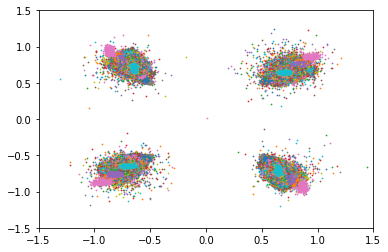

In [51]:
# Plot constellations to see if they are sensible. 


# Set which OFDM symbol to view
start = 180*0
duration = 180*4

# display window size
window = 1.5

for i in range(duration):
    
    plot_res = np.array(freq_data[start+i])[100:1500]
    plt.scatter(plot_res.real, plot_res.imag, s = 0.5)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)


In [80]:
demodulated_data = demodVaryingModulation_std(np.concatenate(tuple(freq_data)), instruction, N)


# This is information shared to the receiver
data_binary_len = len(demodulated_data)

# What to xor with the data. rand_binary calculated in Transmission side. 
rand_for_xor_Rx = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]


In [81]:
# XOR the whole sequence
predict = xor(demodulated_data, rand_for_xor_Rx)

In [82]:
Filename, Length, data_bits = remove_metadata(predict)
print(Filename, Length)

ValueError: invalid literal for int() with base 10: '�\n�2�Uͪ��6�\x10\x14�9\x11f�<�\x19�\x06�\x14,����.�^���\x1eb�.��m��-9\x14?�]}\x06\x83\x1f�5�C�U�˳En�`\r�\x7fu�j�]<��N(����P�M�z\x0b1\x12ē.Z�'

In [83]:
# If it is NOT text, don't include .decode('utf-8', 'replace')
decoded = str_to_bytearray(data_bits)#.decode('utf-8', 'replace')

In [84]:
decoded

bytearray(b'I aM happy to join with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation.\n\nFive score years ago, a great American, in whose symbolic shadow we stand today, signed the Emancipation Proclamation. This momentous decree came as a great beacon light of hope to millions of Negro slaves who had been seared in the flames of withering injustice. It came as a joyous daybreak to end the long night of their captivity.\n\nBut one hundred years later, the Negro still is not free. One hundred years later, the life of the Negro is still sadly crippled by the manacles of segregation and the chains of discrimination. One hundred years later, the Negro lives on a lonely island of poverty in the midst of a vast ocean of material prosperity. One hundred years later, the Negro is still languished in the corners of American society and finds himself an exile in his own land. And so we\'ve come here today to dramatize a shameful con

In [75]:
newFile = open("Data_Files/adam.txt", "wb")
newFile.write(predict)
newFile.close()

In [59]:
correct = 0
est = data_bits
act = song_binary

max_index = min(len(est), len(act))
for i in range(max_index):
    if est[i] == act[i]:
        correct += 1
        
print(correct/max_index)

1.0
